# Using Experimental Data to Find a Soil's Weight Function

As described in Section 2.3 of the article, finding a given soil's weight functions is achieved through a set of experiments in which we measure soil degradation and "first order reversal curves" (FORCs).
This notebook shows how to process the data from these experiments to find soil's weight function for the case with two input variables: salinity, $C$, and Sodium Adsorption Ratio, SAR:

We note that this code is designed for demonstration purposes and that interested users should download the notebook *xxx* for actual use. We also encourage interested users to contact us directly (isaac.kramer@mail.huji.ac.il and yair.mau@mail.huji.ac.il)

# To use the notebook, please click Cell  → Run All.

In [664]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="View/Hide Code"></form>''')

In [665]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.interpolate as interp
from scipy.signal import argrelextrema

from palettable.colorbrewer.sequential import YlGnBu_9

from IPython.display import display_html, Markdown



class app_test(object):
    def __init__(self):                                      
        # import raw data
        self.urlU='https://raw.githubusercontent.com/yairmau/hysteresis-python/master/github_data_u.csv'
        self.urlV='https://raw.githubusercontent.com/yairmau/hysteresis-python/master/github_data_v.csv'
        self.raw_data_constant_u = pd.read_csv(self.urlU,error_bad_lines=False)
        self.raw_data_constant_v = pd.read_csv(self.urlV,error_bad_lines=False)
        # grid dimensions
        self.hys_per_side = 101  # number of hysterons per side for weights
        self.beta_grid_values = np.linspace(0, 100, self.hys_per_side)  # beta grid values
        self.alpha_grid_values = np.linspace(100, 0, self.hys_per_side) # alpha grid values
        self.beta_grid, self.alpha_grid = np.meshgrid(self.beta_grid_values, self.alpha_grid_values)
        self.beta_grids = [self.beta_grid, -np.flip(self.beta_grid, axis = 1)]
        self.alpha_grids = [self.alpha_grid, -np.flip(self.alpha_grid, axis = 0)]
        self.sets = [self.raw_data_constant_u, self.raw_data_constant_v]
        self.weights = ["mu", "nu"]
        # All of the plots, the 2 figures and the gridSpec are clustered into dictionaries
        self.gs = {} 
        self.allPlots = {}
        self.f = {}
        
    #Side functions    
        
    def MarkDownSpace(self,n):
        s = "&nbsp;"
        for i in range(n):
            s = s + "&nbsp;"
        return s
    def DisplaylTables(self,u,v,t1,t2,n1,n2,n3,n4,n5,n6):
        self.fig, self.axes = plt.subplots(1, 2)
        self.gs.update({"Table":(GridSpec(1, 2,
                                    left=0.1, right=1.8,
                                     bottom=0, top=1,
                                     wspace=1.3, hspace=0.4))})
        self.table1_axis = plt.subplot(self.gs["Table"][0, 0])
        self.table2_axis = plt.subplot(self.gs["Table"][0, 1])
        
        
        self.np_u = np.round(u[:5].to_numpy() , 2)
        self.np_v = np.round(v[:5].to_numpy() , 2)
        
        self.table1_axis.table(cellText = self.np_u,colLoc = 'center' ,cellLoc='center',loc='center',colWidths=[0.5,0.5,0.5]
                                             ,colLabels=[n1,n2,n3],
                               colColours=['gray','gray','gray'],bbox=[0, 0, 1, 1] )
        self.table1_axis.axis("off") 
        self.table1_axis.set_title(str(t1)+"\n")
        self.table2_axis.table(cellText = self.np_v, colLoc = 'center' , cellLoc='center',loc='center',colWidths=[0.5,0.5,0.5]
                                             ,colLabels=[n4,n5,n6] 
                               ,colColours=['gray','gray','gray'],bbox=[0, 0, 1, 1] )
        self.table2_axis.axis("off") 
        self.table2_axis.set_title(str(t2)+"\n")
    def draw_arrow(self,ax, start, end):
            ax.annotate('', xy=end, xytext=start, xycoords='data', textcoords='data',
                          arrowprops=dict(headwidth=4.0, headlength=4.0, width=0.2,facecolor = "black", linewidth = 0.5)
                        ,zorder=0)
     
    
    # Variables set up functions which are necessary for both FORC graphing and interpolation 
    
    
    
    def ReversalCurveVariableSetUp1(self):
        self.inputs = self.subset.input_var.to_numpy()
        self.outputs = self.subset.output_var.to_numpy()
        # index of local minimums (beta values from which reversal curves start)
        self.minimums_index = argrelextrema(self.inputs, np.less)[0]
        self.minimums_index = np.concatenate((np.array([0]), self.minimums_index))  # last value
        # index of local maximum (alpha values at which reversal curves stop)
        self.maximums_index = argrelextrema(self.inputs, np.greater)[0]
        self.maximums_index = np.concatenate((self.maximums_index, np.array([len(self.inputs) - 1])))  # last value
        # empty arrays to which we will add alpha/beta values used in experiment and output
        self.betas_reversal = np.empty(0)  # beta values
        self.alphas_reversal = np.empty(0)  # alpha values
        self.F_values = np.empty(0)  # output values
    
    def ReversalCurveVariableSetUp2(self,i): 
        # number of points until local maximum
        self.length = self.maximums_index[i] - self.minimums_index[i] + 1
        # beta_0 value 
        self.beta_0 = np.full((self.length), self.inputs[self.minimums_index[i]])  # does not change along reversal curve
        self.betas_reversal = np.concatenate((self.betas_reversal, self.beta_0))  # concentate to existing values
        # alpha values
        self.alphas = self.inputs[self.minimums_index[i]:self.minimums_index[i]
                                  + self.length]  # move along reversal curve from local min to local max
        self.alphas_reversal = np.concatenate((self.alphas_reversal, self.alphas)) 
        
        # output values 
        self.reversal_curve_values = self.outputs[self.minimums_index[i]:self.minimums_index[i] + self.length]
                                                        # move along reversal curves (i.e., at beta_0, alpha)
        self.F_alpha_beta_v = 0.5 * (self.reversal_curve_values - self.reversal_curve_values.min())
        self.F_values = np.concatenate((self.F_values, self.F_alpha_beta_v))  # concentate to existing values
   





    def PlotFORC(self , n1 , n2):
        # Plotting
        self.f.update({"FORC":plt.figure(1, figsize=(7,10))})
        self.gs.update({"GsCurve1":(GridSpec(len(self.sets[0].weight_variable.unique()), 1,
                                    left=0.1, right=0.8,
                                     bottom=0, top=1,
                                     wspace=0.0, hspace=0.4))})
        self.gs.update({"GsCurve2":(GridSpec(len(self.sets[1].weight_variable.unique()), 1,
                                    left=1.1, right=1.8,
                                     bottom=0.0, top=1,
                                     wspace=0.0, hspace=0.4))})
        for jj in range(len(self.sets)):
            self.constants = self.sets[jj].weight_variable.unique()
            self.beta_grid = self.beta_grids[jj]
            self.alpha_grid = self.alpha_grids[jj]
            # Creating subplots
            for n in range(len(self.constants)):
                self.allPlots.update({"Data"+str(jj+1)+"Curve"+str(n):plt.subplot(self.gs["GsCurve"+str(jj+1)][n, 0])})                           
            
            # Calculating Data for FORC
            # The max list is  created in order to determinate the y limit of the graph
            
            for ii in range(len(self.constants)):
                # data corresponding to specific u value
                self.subset = self.sets[jj].loc[self.sets[jj]['weight_variable'] == self.constants[ii]]  
                self.ReversalCurveVariableSetUp1()
                self.max_list_FORC = []
                # loop for each beta_0 to isolate values associated with reversal curves
                for i in range(len(self.minimums_index)):
                    self.ReversalCurveVariableSetUp2(i)
                    # plot reversal curve
                    self.allPlots["Data"+str(jj+1)+"Curve"+str(ii)].plot(self.alphas, self.reversal_curve_values)
                    self.max_list_FORC.append(self.reversal_curve_values.max())
                
                # Graphs adjustments
                
                self.FORC_max = max(self.max_list_FORC)
                self.FORC_plot = self.allPlots["Data"+str(jj+1)+"Curve"+str(ii)] 
                self.FORC_plot.spines['right'].set_visible(False)
                self.FORC_plot.spines['top'].set_visible(False)
                self.FORC_plot.spines['left'].set_visible(False)
                self.FORC_plot.spines['bottom'].set_visible(False)
                if jj==0:
                    self.FORC_plot.set_xlim([0,106])
                    self.FORC_plot.set_ylim([0,self.FORC_max*1.2]) 
                    self.draw_arrow(self.FORC_plot, (0,0),(106, 0))
                    self.FORC_plot.annotate('', xy=(0, 0), xycoords=('data'),
                                  xytext=(0, self.FORC_max*1.2), textcoords='data',
                                  ha='left', va='center',
                                  arrowprops=dict(arrowstyle='<|-', fc='black'),zorder=2)
                    self.FORC_plot.text(-0.02, self.FORC_max*1.3, r"$rK_s$")
                    self.FORC_plot.text(108, 0, "Salinity")
                    self.FORC_plot.set_title(n1[ii])
                if jj==1:
                    self.FORC_plot.set_xlim([-100,6])
                    self.FORC_plot.set_ylim([0,self.FORC_max*1.2]) 
                    self.draw_arrow(self.FORC_plot, (-100,0),(6, 0))
                    self.FORC_plot.set_xticklabels([0,20,40,60,80,100]) 
                    self.FORC_plot.annotate('', xy=(-100, 0), xycoords=('data'),
                                  xytext=(-100, self.FORC_max*1.2), textcoords='data',
                                  ha='left', va='center',
                                  arrowprops=dict(arrowstyle='<|-', fc='black'),zorder=2)
                    self.FORC_plot.text(-100.02, self.FORC_max*1.3, r"$rK_s$")
                    self.FORC_plot.text(8, 0, "SAR")
                    self.FORC_plot.set_title(n2[ii])

    def InterpolateAndPlotWeight(self,n1,n2):
                
        # Plotting
        self.f.update({"Weight":plt.figure(2, figsize=(7,10))})
        self.gs.update({"GsWeight1":(GridSpec(len(self.sets[0].weight_variable.unique()), 1,
                                    left=0.1, right=0.8,
                                     bottom=0, top=1,
                                     wspace=0.0, hspace=0.4))})
        self.gs.update({"GsWeight2":(GridSpec(len(self.sets[1].weight_variable.unique()), 1,
                                    left=1.1, right=1.8,
                                     bottom=0.0, top=1,
                                     wspace=0.0, hspace=0.4))})
        self.gs.update({"ColorbarGs":(GridSpec(1, 1,
                                    left=1.9, right=2,
                                     bottom=0.8, top=1,
                                     wspace=0.0, hspace=0.4))})
        self.allPlots.update({"Colorbar":plt.subplot(self.gs["ColorbarGs"][0, 0])}) 
        for jj in range(len(self.sets)):
            self.constants = self.sets[jj].weight_variable.unique()
            self.beta_grid = self.beta_grids[jj]
            self.alpha_grid = self.alpha_grids[jj]
            
            for g in range(len(self.constants)):
                self.allPlots.update({"Data"+str(jj+1)+"Weight"+str(g):plt.subplot(self.gs["GsWeight"+str(jj+1)][g, 0])})
                self.W_plot = self.allPlots["Data"+str(jj+1)+"Weight"+str(g)]                     
                self.W_plot.set_yticklabels([])
                self.W_plot.set_xticklabels([])
                self.W_plot.set_aspect('equal', adjustable='box')
                self.W_plot.axis('off')
                
                
                if jj==0:
                    self.W_plot.set_title(n1[g])
                    self.W_plot.set_xlim([0,115])
                    self.W_plot.set_ylim([0,115])
                    self.W_plot.annotate('', xy=(0, 0), xycoords=('data'),
                                  xytext=(0, 110), textcoords='data',
                                  ha='left', va='center',
                                  arrowprops=dict(arrowstyle='<|-', fc='black'),zorder=2)
                    #self.W_plot.axvline(x=0,ymin=0.005,ymax=0.01,c="black",linewidth=1,zorder=10, clip_on=False) 
                    self.draw_arrow(self.W_plot, (0,0),(110, 0))
                    self.W_plot.text(113, 0, "\u03B2") 
                    self.W_plot.text(0, 113, "\u03B1")
                if jj==1:
                    self.W_plot.set_title(n2[g])
                    self.W_plot.set_xlim([-100,5])
                    self.W_plot.set_ylim([-100,5])
                    self.W_plot.annotate('', xy=(-100, -100), xycoords=('data'),
                                  xytext=(-100, 10), textcoords='data',
                                  ha='left', va='center',
                                  arrowprops=dict(arrowstyle='<|-', fc='black'),zorder=2)
                    self.draw_arrow(self.W_plot, (-100,-100),(0, -100))
                    self.W_plot.text(13, -100, "\u03B2") 
                    self.W_plot.text(-100, 13, "\u03B1")
                    
            #self.allPlots.update({"Colorbar":plt.subplot(self.gs["ColorbarGs"][0, 0])})         
                
            
            # Setting up once again variables for interpolation
            self.F_grid = np.zeros((self.hys_per_side, self.hys_per_side, len(self.constants)))# F/G values during reversal curves
            self.betas_int = np.empty(0)  # beta values for interpolation
            self.alphas_int = np.empty(0)  # alpha values for interpolation
            self.u_int = np.empty(0)  # output values for interpolation
            self.F_int = np.empty(0)  # F values for interpolation       
            for ii in range(len(self.constants)):
                self.subset = self.sets[jj].loc[self.sets[jj]['weight_variable'] == self.constants[ii]]  
                self.ReversalCurveVariableSetUp1()
                for i in range(len(self.minimums_index)):
                    self.ReversalCurveVariableSetUp2(i)
                
                
                
                # Interpolation
                
                
                self.zfun_smooth_rbf = interp.Rbf(self.betas_reversal, self.alphas_reversal, self.F_values,
                                                  function='cubic',smooth=0)
                self.z_dense_smooth_rbf = self.zfun_smooth_rbf(self.beta_grid, self.alpha_grid)
                self.F_grid = np.where(self.alpha_grid >= self.beta_grid, self.z_dense_smooth_rbf, np.nan)
        
                # calculate d^2 f_{alpha,beta} and weights
                self.step = self.beta_grid_values[1]
                self.matrix1 = self.F_grid[:-2, 2:]
                self.matrix2 = self.F_grid[2:, 2:]
                self.matrix3 = self.F_grid[:-2, :-2]
                self.matrix4 = self.F_grid[2:, :-2]
                self.weights_grid = (self.matrix3 + self.matrix2 - self.matrix1 - self.matrix4) / (4 * self.step ** 2)
        
                # add rows/columns containing nan to side to keep old dimensions
                self.newrow = np.empty((self.hys_per_side - 2))
                self.newcol = np.empty((self.hys_per_side, 1))
                self.newrow[:] = np.nan
                self.newcol[:] = np.nan
                self.weights_grid = np.vstack([self.newrow, self.weights_grid, self.newrow])
                self.weights_grid = np.hstack([self.newcol, self.weights_grid, self.newcol])
        
                # remove values where interpolating created a negative value
                with np.errstate(invalid='ignore'):
                    self.weights_grid = np.where(self.weights_grid < 0, 0, self.weights_grid)
        
                # reinterpolate using 'nearest' to fill values on border
                self.array = np.ma.masked_invalid(self.weights_grid)
                self.beta_masked = self.beta_grid[~self.array.mask]
                self.alpha_masked = self.alpha_grid[~self.array.mask]
                self.newarr = self.array[~self.array.mask]
                self.weights_grid = interp.griddata((self.beta_masked, self.alpha_masked), self.newarr.ravel(),
                                                    (self.beta_grid, self.alpha_grid),method='nearest')
        
                # eliminate values outside preisach triangle
                self.weights_grid = np.where(self.alpha_grid >= self.beta_grid, self.weights_grid, np.nan)
        
                # flatten interpolated values so that they can be used later for 3-D interpolation
                self.beta_flat = self.beta_grid.flatten()
                self.alpha_flat = self.alpha_grid.flatten()
                self.u_flat = np.full((self.hys_per_side * self.hys_per_side), self.constants[ii])
                self.F_flat = self.weights_grid.flatten()
        
                # concatenate with existing values
                self.betas_int = np.concatenate((self.betas_int, self.beta_flat))
                self.alphas_int = np.concatenate((self.alphas_int, self.alpha_flat))
                self.u_int = np.concatenate((self.u_int, self.u_flat))
                self.F_int = np.concatenate((self.F_int, self.F_flat))
        
                # plot weight function including a colorbar
                self.W_plot = self.allPlots["Data"+str(jj+1)+"Weight"+str(ii)]
                self.scatter = self.W_plot.scatter(self.beta_grid, self.alpha_grid,
                                                          c=self.weights_grid, s=3,cmap=YlGnBu_9.mpl_colormap,
                                                              vmin=np.nanmin(self.weights_grid),
                                                   vmax=np.nanmax(self.weights_grid))
                if jj == 0 and ii == 0:
                    self.cb =  self.f["Weight"].colorbar(self.scatter,ax=self.allPlots["Colorbar"])
                    self.cb.set_ticks([self.cb.vmin,self.cb.vmax])
                    self.cb.set_ticklabels(["Weight = 0.0","Weight = 1.0"])
                    self.cb.ax.tick_params(labelsize=8) 
                    self.allPlots["Colorbar"].axis("off")
                                                                                                                         
    def SaveArray(self):
        self.points = (self.betas_int, self.alphas_int, self.u_int)
        self.beta_cube, self.alpha_cube, self.u_cube = np.meshgrid(self.beta_grid_values, self.alpha_grid_values,
                                                                       self.beta_grid_values)
        self.mu = interp.griddata(self.points, self.F_int, (self.beta_cube, self.alpha_cube, self.u_cube), method='linear')
        np.save('experimental_data/'+weights[jj]+'.npy', mu)


## 1. Import raw data

The imported data should be stored in two .csv files. The first .csv file contains data from the FORCs in which SAR was held constant. The second .csv file should contain data related to the FORCs in which salinity, $C$ was held constant. Each dataset is stored in a Pandas DataFrame, the headers of which are shown below.


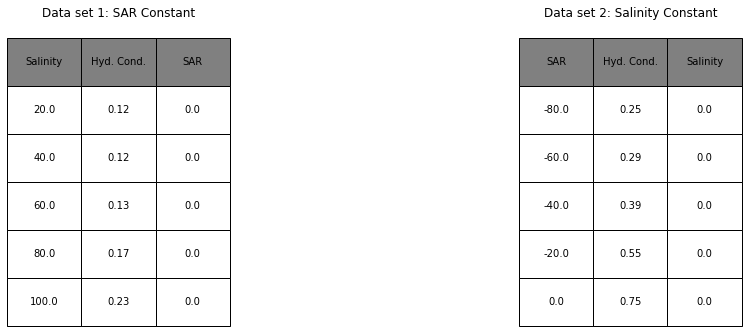

In [666]:
A = app_test()
A.DisplaylTables(A.raw_data_constant_u,A.raw_data_constant_v,"Data set 1: SAR Constant","Data set 2: Salinity Constant","Salinity","Hyd. Cond.","SAR","SAR","Hyd. Cond.","Salinity")

## 2. Display FORCs
We use the imported data to reconstruct the FORCs.

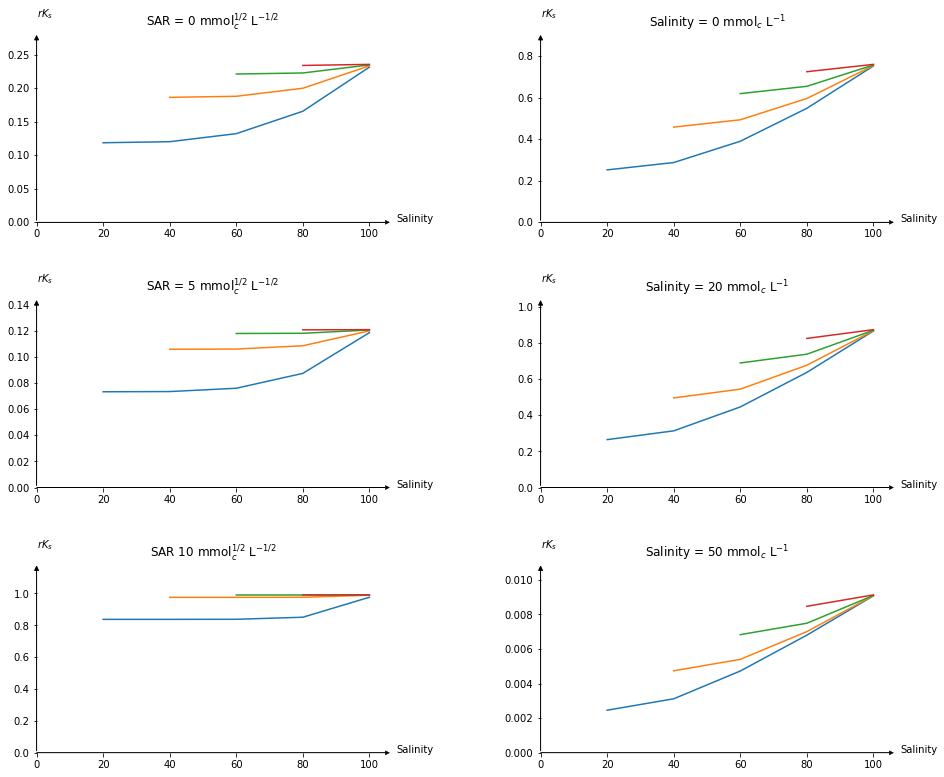

In [667]:
A.PlotFORC([r"SAR = 0 mmol$_c^{1/2}$ L$^{-1/2}$", r"SAR = 5 mmol$_c^{1/2}$ L$^{-1/2}$", r"SAR 10 mmol$_c^{1/2}$ L$^{-1/2}$"],[r"Salinity = 0 mmol$_c$ L$^{-1}$",r"Salinity = 20 mmol$_c$ L$^{-1}$",r"Salinity = 50 mmol$_c$ L$^{-1}$"])

## 3. FORCs are used to calculate weight functions
We use the data from the FORCs to calculate a weight function for each of the known SAR and salinity values, respectively. This is done according to the methodology described in section 5 and by interpolating the measured data across the $alpha,beta$-plane.

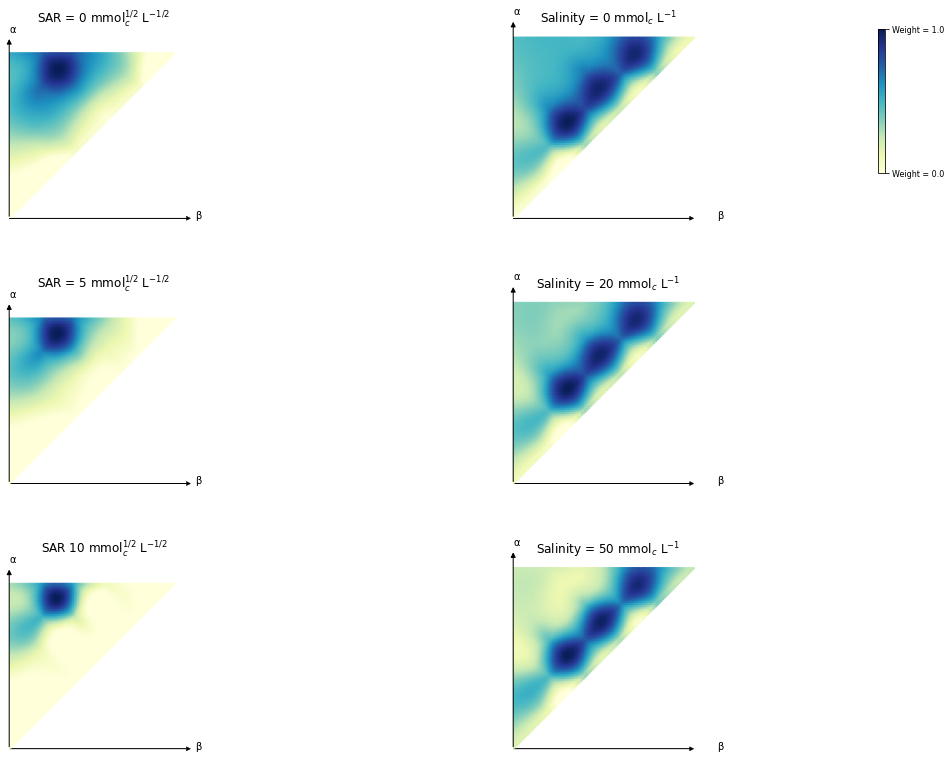

In [668]:
A.InterpolateAndPlotWeight([r"SAR = 0 mmol$_c^{1/2}$ L$^{-1/2}$", r"SAR = 5 mmol$_c^{1/2}$ L$^{-1/2}$", r"SAR 10 mmol$_c^{1/2}$ L$^{-1/2}$"],[r"Salinity = 0 mmol$_c$ L$^{-1}$",r"Salinity = 20 mmol$_c$ L$^{-1}$",r"Salinity = 50 mmol$_c$ L$^{-1}$"])

## 4. Interpolate for all SAR and Salinity Values

The final step is to interpolate from the known SAR and salinity values, so that we have a weight function for all SAR and salinity values. This step is not performed in this notebook, but is included in *xxxx*.